In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# let's silence all the annoying Future warnings from Pandas:
import pandas as pd

In [3]:
np.random.seed(seed=42)

# Annotating the saline cells

I will cheat shamelessly and follow the manuscript as closely as possible - after all, we would want our later analysis to somewhat follow the results of the paper.

According to figure 1B of the paper, there are 20 clusters in the data. While the authors didn't necessarily preprocess the same way I did, I can still choose a Leiden resolution that produces a similar number of clusters. I know that there may not be an 1-to-1 correspondence, but hope the data is robust enough once again.

In [4]:
adata = sc.read_h5ad("./saline.h5ad")

I have already done all I needed to do before this point; now I will just cluster and then check if my resolution produces (close to) 20 clusters:

In [5]:
sc.tl.leiden(adata, resolution=0.5)
adata.obs["leiden"].cat.categories.shape

(21,)

Jackpot on the first try, let's keep 21 clusters and see what happens.

Using an excellent [recent description of the orbitofrontal cortex](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6744514/) I can mine marker genes for major cell types:

> Based on the expression of cell type-specific markers, the non-neuronal cells were clustered as: astrocytes (Gja1+), oligodendrocyte (Aspa+), newly formed oligodendrocytes (Bmp4+), oligodendrocyte precursors (Pdgfra+), microglia (C1qa+) and endothelial cells (Flt1+) (Fig. 1c, d). The neurons express Snap25 and can be divided into excitatory (Slc17a7+) and inhibitory (Gad2+) neurons

In [6]:
orbitofrontal = ["Gja1", "Aspa", "Bmp4", "Pdgfra", "C1qa", "Flt1", "Snap25", "Slc17a7", "Gad2"]

Before plotting the dendrogram, I would like to organize the clusters a bit, in the hope of making patterns in gene expression easier to see.

In [7]:
sc.tl.dendrogram(adata, groupby="leiden")

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


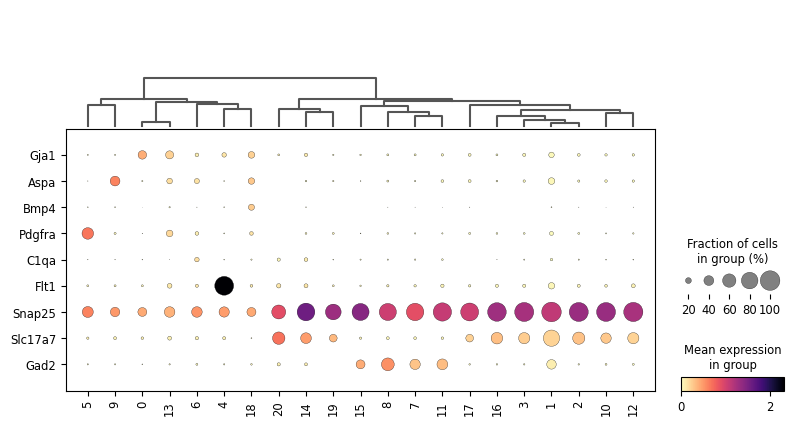

In [8]:
sc.pl.dotplot(adata, var_names=orbitofrontal, groupby="leiden", swap_axes=True, cmap="magma_r", dendrogram=True)

We notice that the intensity of _Snap25_ expression separates putative neurons from non-neurons; and that Gad2 and Slc17a7 nicely separate 5 inhibitory GABA-ergic clusters from 9 excitatory, glutamatergic clusters. We have also already hit the jackpot with endothelial cells, which are cluster 4, and newly formed oligodendrocytes, who based on Bmp4 expression must be cluster 18.

Pdgfra expression is not extremely specific, but it certainly looks like cluster 5 might be oligodendrocyte precursors. C1qa is not great either, but 6 is a candidate microglia cluster for now.

In [9]:
replace = {
    "4": "endothelial",
    "18": "new ODC",
    "5": "OPC",
}

Next, we can consult Fig. 1 from the paper, where an array of helpful markers is used. Some will overlap with what we found already:

In [10]:
paper_markers = ["Ptgds", "Rgs5", "Pecam1", "Opalin", "Mog", "Pdgfra", "Cx3cr1", "Acsbg1", "Vip",
    "Sst", "Pvalb", "Lamp5", "Gad2", "Dlx6os1", "Foxp2", "Rorb", "Il1rapl2", "Arhgap15", "Pld5",
    "Slc17a7", "Snap25",]

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


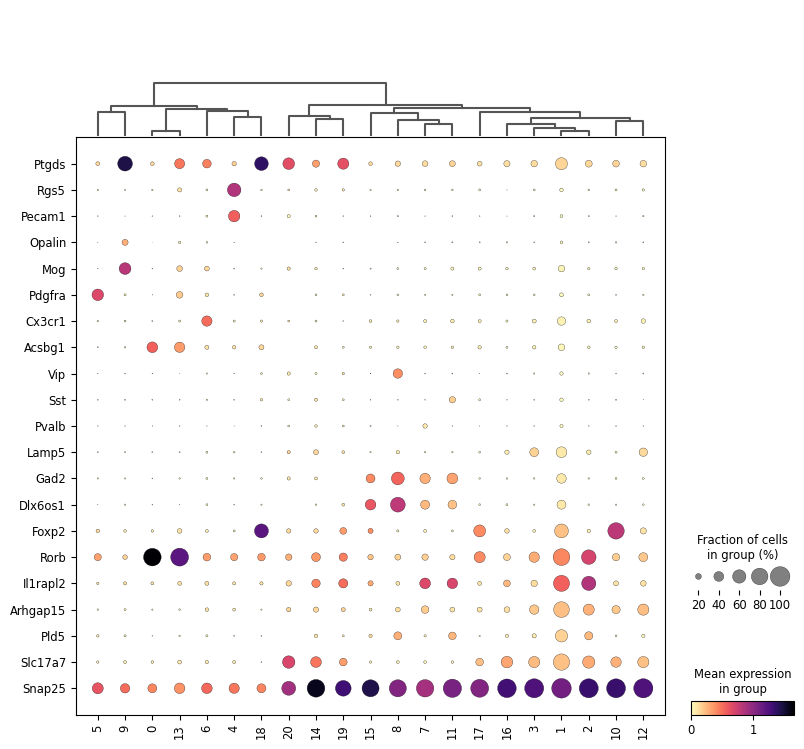

In [11]:
sc.pl.dotplot(adata, var_names=paper_markers, groupby="leiden", swap_axes=True, cmap="magma_r", dendrogram=True)

Things becoming a lot clearer:

- 9 is Mog+, Opalin+, and Ptgds+, so it must be oligodendrocytes (ODC)
- 0 is Rorb+ and Acsbg1+, so we have found the astrocytes. 13 must be the same as well.
- 6 is Cx3cr1+, therefore the microglia
- 4, except for Flit1+, is also Rgs5+ and Pecam1+, so a combination of endothelial and SMC.
- 18 is Foxp2+ and Ptgds+, so it has to be VLMC.

Inside the inhibitory clade, we can see the following:

- 8 is Vip+
- 7 is Pvalb2+
- 11 is Ssp+
- 1 is Lamp5+
- therefore, 15 must be Inh1

Similarly, within the excitatory clade, we can see:

- 10 is Foxp2+, therefore must be Ex3
- 2 is very similar to the Lamp5 cluster, so it must be Ex1
- 17 must then be Ex7, since it is Foxp2+ and Arhgap15-
- Ex4 and Ex2 and Ex8 are the other Lamp5+ glutamatergic clusters, but they are mostly very similar. 12 has some Foxp2, so it should be Ex4.
- it is hard to make judgment calls for the rest, so we're gonna leave them as they are.

In [12]:
replace = {
    "9": "ODC",
    "0": "astrocytes 1",
    "13": "astrocytes 2",
    "6": "microglia",
    "4": "endothelial/SMC",
    "5": "OPC",
    "18": "VLMC",
    "8": "GABA-Vip",
    "7": "GABA-Pvalb2",
    "11": "GABA-Sst",
    "1": "GABA-Lamp5",
    "15": "GABA-Inh1",
    "10": "glut-Ex3",
    "2": "glut-Ex1",
    "17": "glut-Ex7",
    "12": "glut-Ex4",
    "20": "glut-20",
    "14": "glut-14",
    "19": "glut-19",
    "16": "glut-16",
    "3": "glut-3",
}

adata.obs["annot"] = adata.obs["leiden"].cat.rename_categories(replace)

paper_order = ["glut-Ex1", "glut-Ex3", "glut-Ex4", "glut-Ex7", "glut-20", "glut-14", "glut-19",
               "glut-16", "glut-3", "GABA-Inh1", "GABA-Lamp5", "GABA-Pvalb2", "GABA-Sst",
               "GABA-Vip", "astrocytes 1", "astrocytes 2", "microglia", "OPC", "ODC",
               "endothelial/SMC", "VLMC",]

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


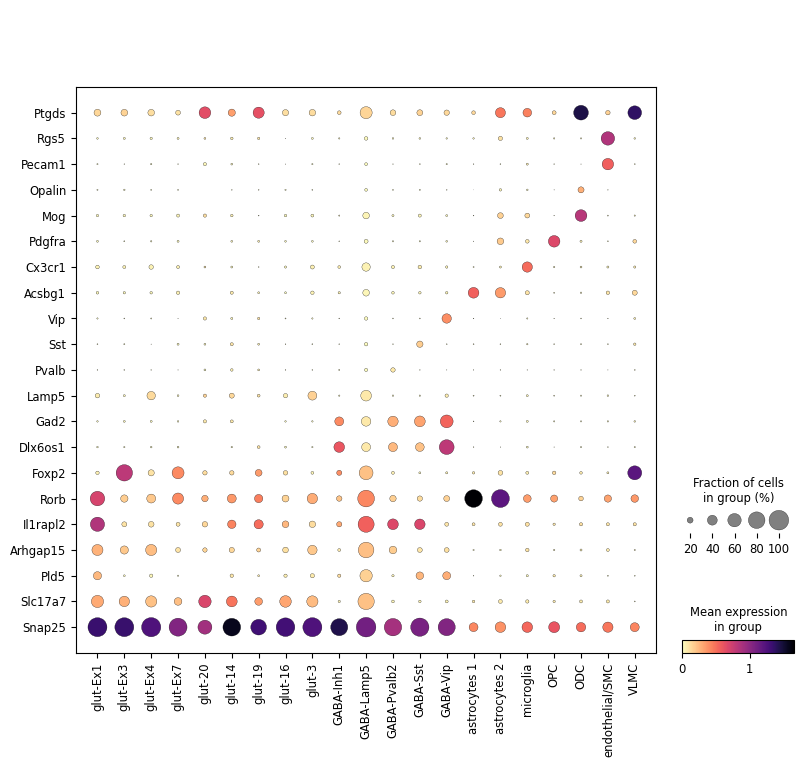

In [13]:
sc.pl.dotplot(adata, var_names=paper_markers, groupby="annot", swap_axes=True, cmap="magma_r", categories_order=paper_order)